In [8]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [9]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [10]:
def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

5000: loss 8.333 time 12.22


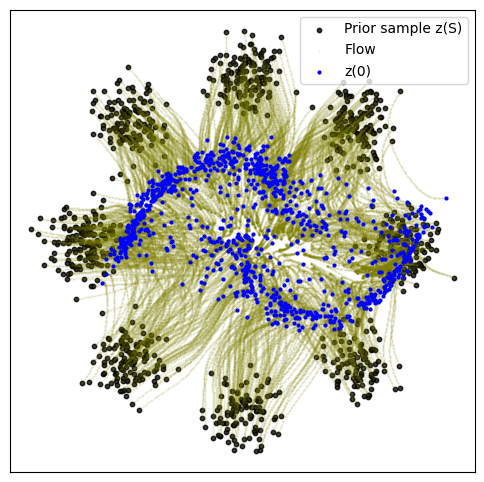

10000: loss 8.827 time 14.33


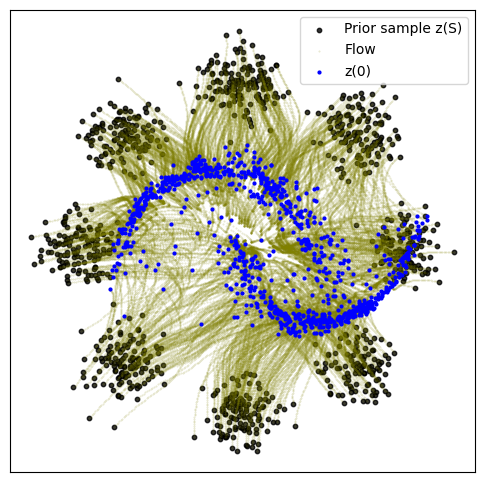

15000: loss 7.586 time 13.14


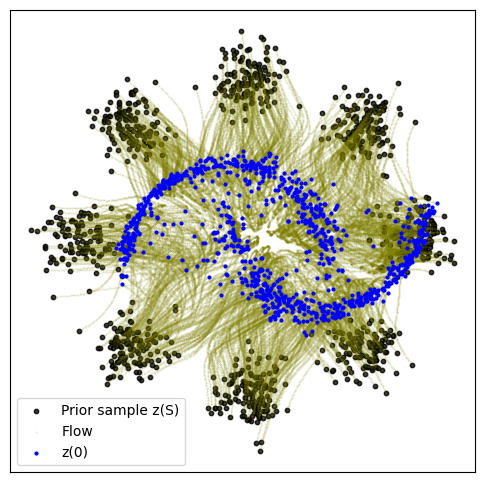

20000: loss 9.251 time 13.64


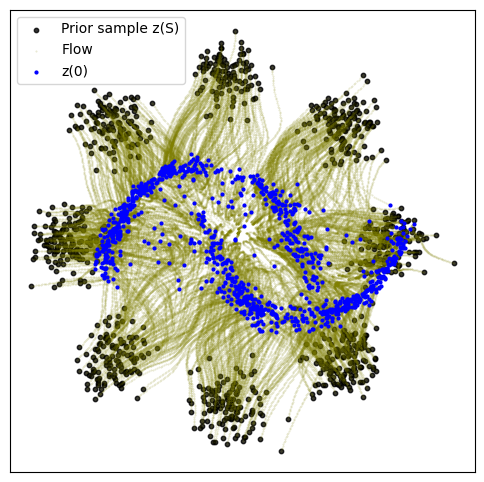

CPU times: user 1min 26s, sys: 3min 33s, total: 5min
Wall time: 54.3 s


In [11]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t = torch.rand(x0.shape[0]).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

torch.Size([1024, 2])
(1024, 2)


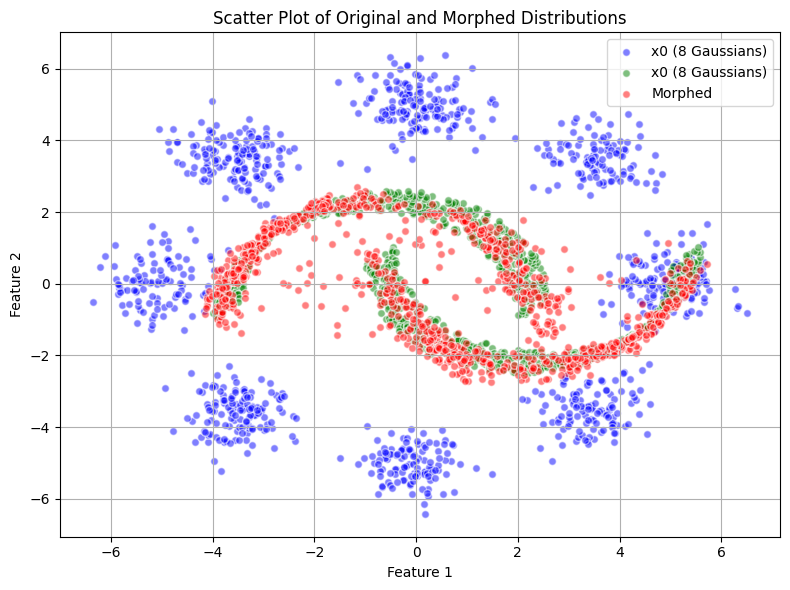

In [107]:
outputson = traj.cpu().numpy()[-1]

test_size = 1024
x0 = sample_8gaussians(test_size)
x1 = sample_moons(test_size)

print( np.shape(x1) )
print( np.shape(outputson) )

plt.figure(figsize=(8, 6))

# Plot x0 distribution
plt.scatter(x0[:, 0], x0[:, 1], 
            c='blue', 
            alpha=0.5, 
            label='x0 (8 Gaussians)', 
            edgecolors='w', 
            s=30)

# Plot x0 distribution
plt.scatter(x1[:, 0], x1[:, 1], 
            c='green', 
            alpha=0.5, 
            label='x0 (8 Gaussians)', 
            edgecolors='w', 
            s=30)

# Plot morphed distribution
plt.scatter(outputson[:, 0], outputson[:, 1], 
            c='red', 
            alpha=0.5, 
            label='Morphed', 
            edgecolors='w', 
            s=30)

plt.title('Scatter Plot of Original and Morphed Distributions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
#### instead of flow matching we use batch OT + regression
import scipy
import torch.nn as nn

# Define the Regressor model
class Regressor(nn.Module):
    def __init__(self, input_dim=2):
        super(Regressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.model(x)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Initialize network, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 256
num_iterations = 50000

start = time.time()
for k in range(1, num_iterations + 1):
    model.train()
    optimizer.zero_grad()

    # Sample data
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    #### Batch Optimal Transport
    with torch.no_grad():
        # Compute the cost matrix on CPU
        M = torch.cdist(x0, x1) ** 2  # Shape: (batch_size, batch_size)
        M_cpu = M.cpu().numpy()

        # Solve the linear sum assignment problem
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(M_cpu)

        # Reorder x1 based on the assignment
        x1_matched = x1[col_ind].to(device)

    # Forward pass
    outputs = model(x0)

    # Compute loss
    loss = criterion(outputs, x1_matched)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Logging
    if k % 100 == 0 or k == 1:
        elapsed = time.time() - start
        print(f"Iteration {k}/{num_iterations} - Loss: {loss.item():.4f} - Time Elapsed: {elapsed:.2f}s")
        start = time.time()

Iteration 1/50000 - Loss: 4.7859 - Time Elapsed: 0.01s
Iteration 100/50000 - Loss: 0.2921 - Time Elapsed: 0.56s
Iteration 200/50000 - Loss: 0.3530 - Time Elapsed: 0.54s
Iteration 300/50000 - Loss: 0.3493 - Time Elapsed: 0.55s
Iteration 400/50000 - Loss: 0.4350 - Time Elapsed: 0.54s
Iteration 500/50000 - Loss: 0.3327 - Time Elapsed: 0.54s
Iteration 600/50000 - Loss: 0.3591 - Time Elapsed: 0.62s
Iteration 700/50000 - Loss: 0.2827 - Time Elapsed: 0.55s
Iteration 800/50000 - Loss: 0.2270 - Time Elapsed: 0.56s
Iteration 900/50000 - Loss: 0.2708 - Time Elapsed: 0.54s
Iteration 1000/50000 - Loss: 0.3045 - Time Elapsed: 0.59s
Iteration 1100/50000 - Loss: 0.2023 - Time Elapsed: 0.69s
Iteration 1200/50000 - Loss: 0.2532 - Time Elapsed: 0.56s
Iteration 1300/50000 - Loss: 0.1952 - Time Elapsed: 0.55s
Iteration 1400/50000 - Loss: 0.2579 - Time Elapsed: 0.54s
Iteration 1500/50000 - Loss: 0.2326 - Time Elapsed: 0.54s
Iteration 1600/50000 - Loss: 0.3059 - Time Elapsed: 0.58s
Iteration 1700/50000 - Los

In [109]:
### evaluate the model ...
test_size = 1024
x0 = sample_8gaussians(test_size)
x1 = sample_moons(test_size)
morphed = model(x0)

print( morphed.size )
print( morphed[:10] )


<built-in method size of Tensor object at 0x2aa92f480>
tensor([[-0.1965, -0.7993],
        [ 1.8605,  0.7053],
        [-3.5168, -0.5256],
        [-3.2022,  0.0570],
        [ 0.1577, -1.4590],
        [-2.3702,  1.8207],
        [-2.2009,  1.9458],
        [ 2.9849, -2.2687],
        [ 4.5087, -1.0347],
        [ 4.1448, -1.4285]], grad_fn=<SliceBackward0>)


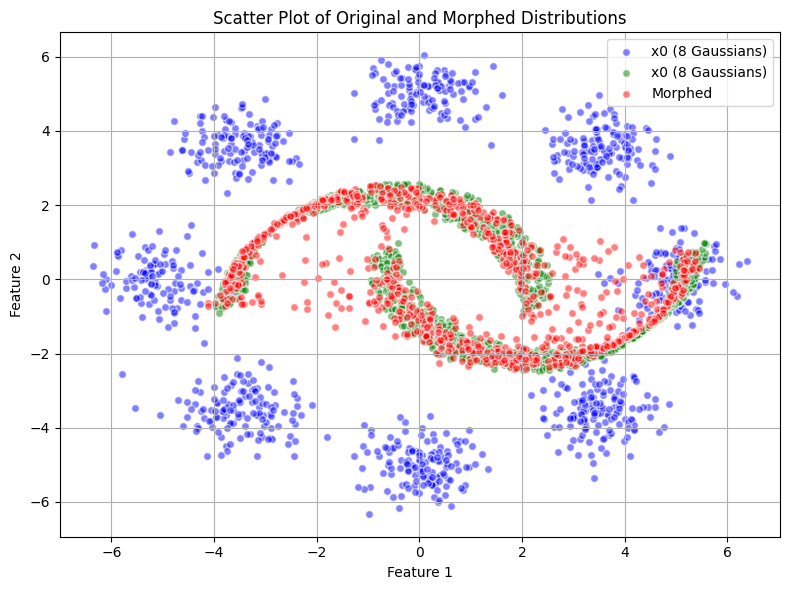

In [110]:
plt.figure(figsize=(8, 6))

# Plot x0 distribution
plt.scatter(x0[:, 0], x0[:, 1], 
            c='blue', 
            alpha=0.5, 
            label='x0 (8 Gaussians)', 
            edgecolors='w', 
            s=30)

# Plot x0 distribution
plt.scatter(x1[:, 0], x1[:, 1], 
            c='green', 
            alpha=0.5, 
            label='x0 (8 Gaussians)', 
            edgecolors='w', 
            s=30)

# Plot morphed distribution
plt.scatter(morphed[:, 0].detach().numpy(), morphed[:, 1].detach().numpy(), 
            c='red', 
            alpha=0.5, 
            label='Morphed', 
            edgecolors='w', 
            s=30)

plt.title('Scatter Plot of Original and Morphed Distributions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

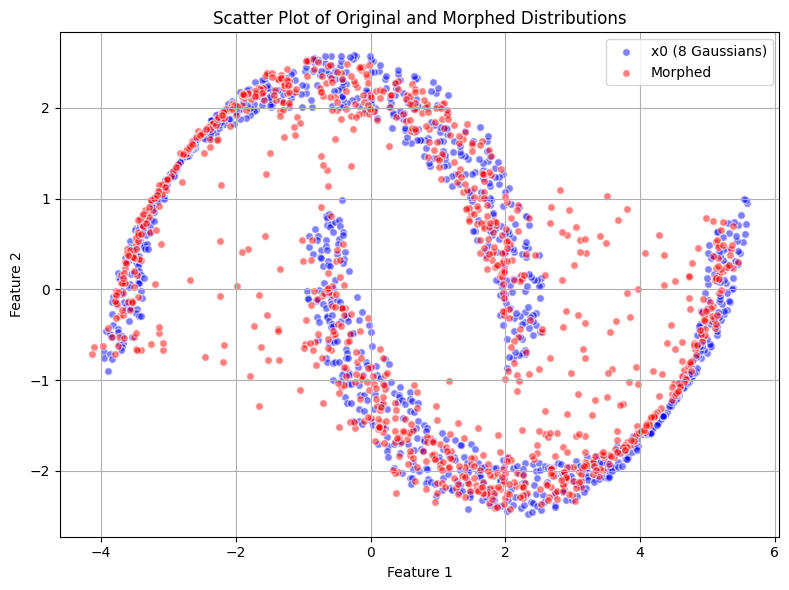

In [111]:
plt.figure(figsize=(8, 6))

# Plot x0 distribution
plt.scatter(x1[:, 0], x1[:, 1], 
            c='blue', 
            alpha=0.5, 
            label='x0 (8 Gaussians)', 
            edgecolors='w', 
            s=30)

# Plot morphed distribution
plt.scatter(morphed[:, 0].detach().numpy(), morphed[:, 1].detach().numpy(), 
            c='red', 
            alpha=0.5, 
            label='Morphed', 
            edgecolors='w', 
            s=30)

plt.title('Scatter Plot of Original and Morphed Distributions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
##### Now we train a BDT
########################

import torch
import numpy as np
import scipy.optimize
import time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles, make_moons
from sklearn.multioutput import MultiOutputRegressor

def collect_data(batch_size, num_iterations):
    X = []
    Y = []
    start_time = time.time()
    
    for k in range(1, num_iterations + 1):
        # Sample data
        x0 = sample_8gaussians(batch_size)  # Shape: (batch_size, 2)
        x1 = sample_moons(batch_size)       # Shape: (batch_size, 2)
        
        #### Batch Optimal Transport
        # Compute the cost matrix
        M = np.linalg.norm(x0[:, np.newaxis, :] - x1[np.newaxis, :, :], axis=2) ** 2  # Shape: (batch_size, batch_size)
        
        # Solve the linear sum assignment problem
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(M)
        
        # Reorder x1 based on the assignment to get matched pairs
        x1_matched = x1[col_ind]  # Shape: (batch_size, 2)
        
        # Append to dataset
        X.append(x0)           # Inputs
        Y.append(x1_matched)   # Targets
        
        # Logging
        if k % 100 == 0 or k == 1:
            elapsed = time.time() - start_time
            print(f"Data Collection Iteration {k}/{num_iterations} - Time Elapsed: {elapsed:.2f}s")
            start_time = time.time()
    
    # Concatenate all batches
    X = np.vstack(X)  # Shape: (num_iterations * batch_size, 2)
    Y = np.vstack(Y)  # Shape: (num_iterations * batch_size, 2)
    
    return X, Y

def train_bdt(X, Y):
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Initialize the BDT model wrapped with MultiOutputRegressor
    base_regressor = GradientBoostingRegressor(
        n_estimators=150,        # Number of boosting stages
        learning_rate=0.1,       # Shrinkage rate
        max_depth=4,             # Maximum depth of the individual regression estimators
        random_state=42,
        loss='squared_error'     # Updated loss parameter
    )
    bdt_model = MultiOutputRegressor(base_regressor)
    
    # Train the model
    print("Training the BDT model...")
    start_time = time.time()
    bdt_model.fit(X_train, Y_train)
    training_time = time.time() - start_time
    print(f"BDT training completed in {training_time:.2f}s")
    
    # Evaluate the model
    Y_pred = bdt_model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    print(f"Test MSE: {mse:.4f}")
    
    return bdt_model, X_test, Y_test, Y_pred

def visualize_results(X_test, Y_test, Y_pred, num_points=1000):
    plt.figure(figsize=(8, 6))
    
    # Plot true mappings
    plt.scatter(Y_test[:num_points, 0], Y_test[:num_points, 1],
                c='green', alpha=0.5, label='True', edgecolors='w', s=20)
    plt.title('Target')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    
    # Plot predicted mappings
    plt.scatter(Y_pred[:num_points, 0], Y_pred[:num_points, 1],
                c='red', alpha=0.5, label='Predicted', edgecolors='w', s=20)
    plt.title('BDT Predicted Morphed Distribution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    
    # Plot residuals
    plt.scatter(X_test[:num_points, 0], X_test[:num_points, 1],
                c='blue', alpha=0.5, label='Residuals', edgecolors='w', s=20)
    plt.title('Nominal')
    plt.xlabel('Residual Feature 1')
    plt.ylabel('Residual Feature 2')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Starting data collection...
Data Collection Iteration 1/2000 - Time Elapsed: 0.02s
Data Collection Iteration 100/2000 - Time Elapsed: 0.50s
Data Collection Iteration 200/2000 - Time Elapsed: 0.50s
Data Collection Iteration 300/2000 - Time Elapsed: 0.49s
Data Collection Iteration 400/2000 - Time Elapsed: 0.50s
Data Collection Iteration 500/2000 - Time Elapsed: 0.51s
Data Collection Iteration 600/2000 - Time Elapsed: 0.50s
Data Collection Iteration 700/2000 - Time Elapsed: 0.50s
Data Collection Iteration 800/2000 - Time Elapsed: 0.50s
Data Collection Iteration 900/2000 - Time Elapsed: 0.49s
Data Collection Iteration 1000/2000 - Time Elapsed: 0.49s
Data Collection Iteration 1100/2000 - Time Elapsed: 0.50s
Data Collection Iteration 1200/2000 - Time Elapsed: 0.51s
Data Collection Iteration 1300/2000 - Time Elapsed: 0.50s
Data Collection Iteration 1400/2000 - Time Elapsed: 0.49s
Data Collection Iteration 1500/2000 - Time Elapsed: 0.50s
Data Collection Iteration 1600/2000 - Time Elapsed: 0.49

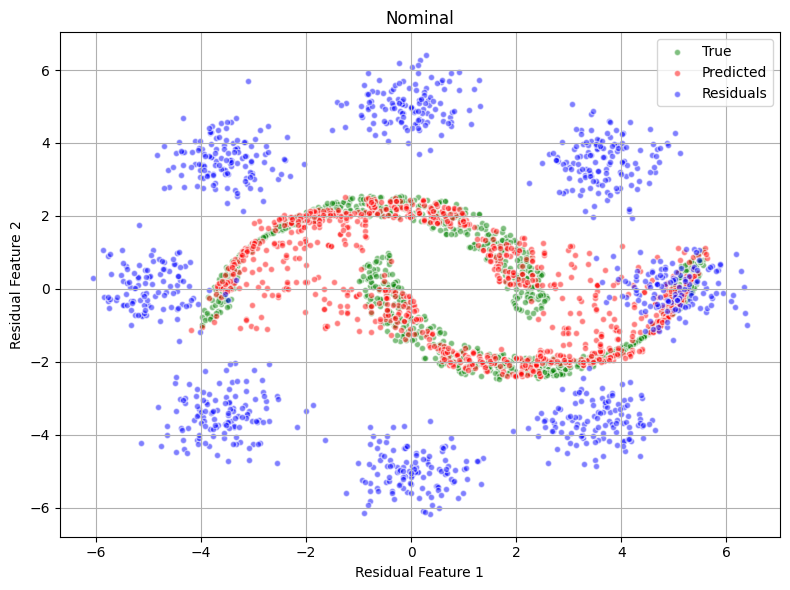

In [124]:
def main():
    # Parameters
    batch_size = 256
    num_iterations = 2000  # Adjust based on available memory and computational resources
    
    # Step 1: Data Collection
    print("Starting data collection...")
    X, Y = collect_data(batch_size, num_iterations)
    print(f"Data collection completed. Total samples: {X.shape[0]}")
    
    # Step 2: Train BDT Model
    bdt_model, X_test, Y_test, Y_pred = train_bdt(X, Y)
    
    # Step 3: Visualize Results
    visualize_results(X_test, Y_test, Y_pred, num_points=1024)
    
if __name__ == "__main__":
    main()